<a href="https://colab.research.google.com/github/MunySafitri/Pengolahan-Citra-Digital/blob/main/PCD_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project PCD 

|Nama|NIM|
|----|---|
|Muhamad Iqbal Fatikhussabil|19/442477/PA/19226|
|Thomas Budiarjo|20/459279/PA/19940|
|Rachel Naragifta|21/482074/PA/21018|
|Diki Bagastama|21/479920/PA/20824|
|Azzakhruf Aryan Nur Ihsan|21/477261/PA/20646|
|I Gusti Agung Premananda|21/472829/PA/20432|
|Muny Safitri|22/206376/NUGM/01039|



# Initialize Library and Display Image

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
img = cv.imread('sample.jpg',-1)

In [ ]:
# function to display the image
def display(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    plt.figure(figsize=(12,10))
    plt.xticks([]), plt.yticks([])
    plt.imshow(img)
    plt.show()

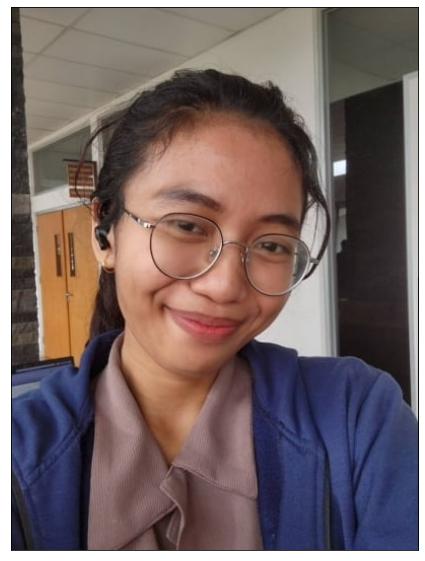

In [ ]:
display(img)

# Skin Masking


## Filter out the background

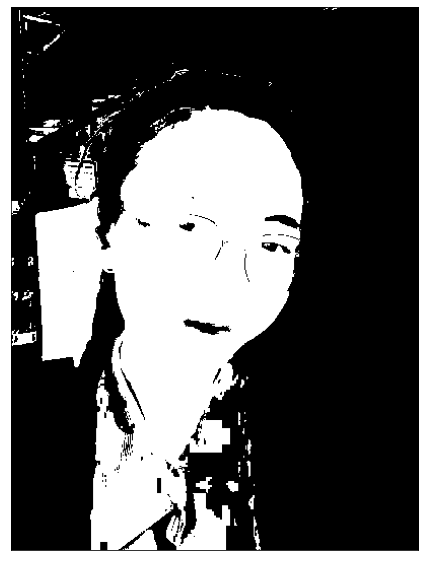

In [ ]:
# skin tone range
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")

# convert BGR to HSV
converted = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# find the colors within the specified boundaries and apply
# the mask
skinMask = cv.inRange(converted, lower, upper)
display(skinMask)

## Apply opening using an elliptical kernel

In [ ]:
def square_slice(padded_img, w, i, j):
  ip, jp = (i + w), (j + w)
  square = padded_img[(ip - w):(ip + w + 1), (jp - w):(jp + w + 1)]
  return square

def dilate(input_img, kernel):
  w, h = input_img.shape
  pad_w = int((kernel.shape[0] - 1)/2)  # assume an odd square kernel
  output = input_img.copy()
  padded_img = np.pad(input_img, pad_w, mode='constant', constant_values=0)
  for i in range(w):
    for j in range(h):
      square = (square_slice(padded_img, pad_w, i, j)/255).astype(np.uint8)
      if np.any(square & kernel) == 1:
        output[i, j] = 255
      else:
        output[i, j] = 0
  return output.astype(np.uint8)

def erode(input_img, kernel):
  w, h = input_img.shape
  pad_w = int((kernel.shape[0] - 1)/2)  # assume an odd square kernel
  output = np.zeros((w, h))
  padded_img = np.pad(input_img, pad_w, mode='constant', constant_values=0)
  for i in range(w):
    for j in range(h):
      square = (square_slice(padded_img, pad_w, i, j)/255).astype(np.uint8)
      square = np.invert(square)
      if np.any(square & kernel) == 1:
        output[i, j] = 0
      else:
        output[i, j] = 255
  return output.astype(np.uint8)

def iterate(iterations, func, input_img, kernel):
  output = input_img
  for i in range(iterations):
    output = func(input_img, kernel)
  return output

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]]


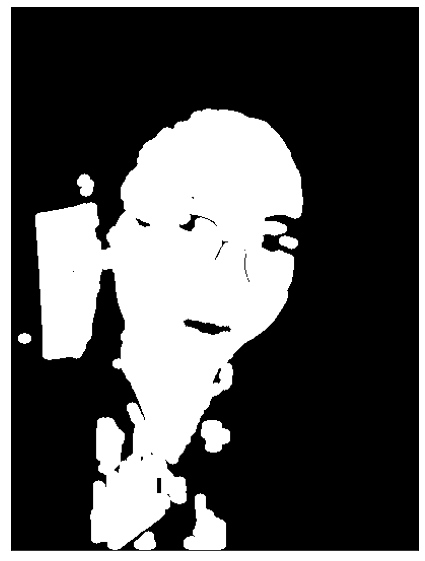

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
print(kernel)

# skinMask = cv.erode(skinMask, kernel, iterations = 2)
# skinMask = cv.dilate(skinMask, kernel, iterations = 2)

skinMask = iterate(2, erode, skinMask, kernel)
skinMask = iterate(2, dilate, skinMask, kernel)
display(skinMask)

## Blur the mask to reduce noise

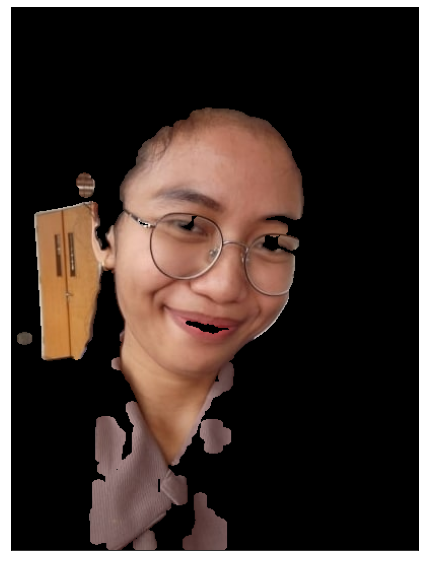

In [ ]:
skinMask = cv.GaussianBlur(skinMask, (3, 3), 0)
skin = cv.bitwise_and(img, img, mask = skinMask)

display(skin)

# Beautify

## Obtain high pass by subtracting blurred image from original

Blur using bilateral filter because it preserves edges

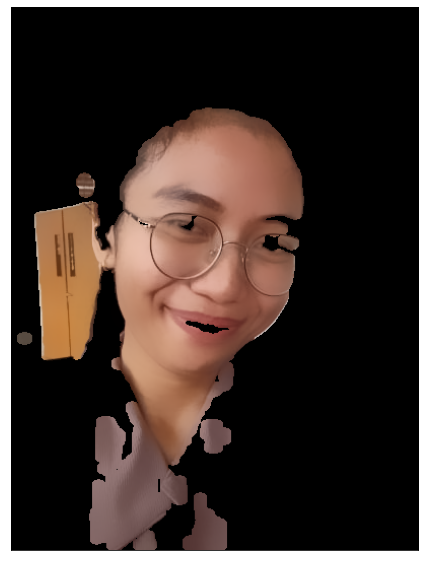

In [ ]:
blur = cv.bilateralFilter(skin, 28, 45, 45)
display(blur)

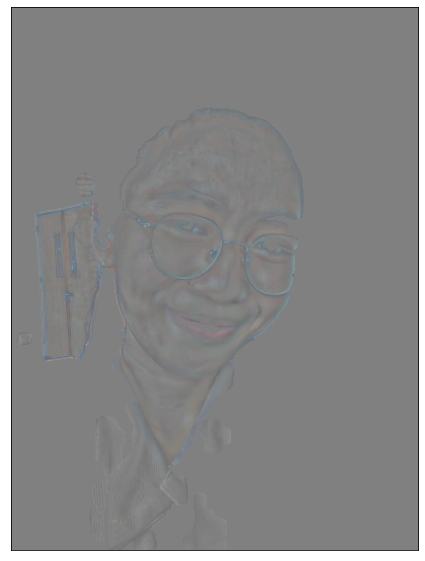

In [ ]:
hpf = skin - blur + 128
display(hpf)

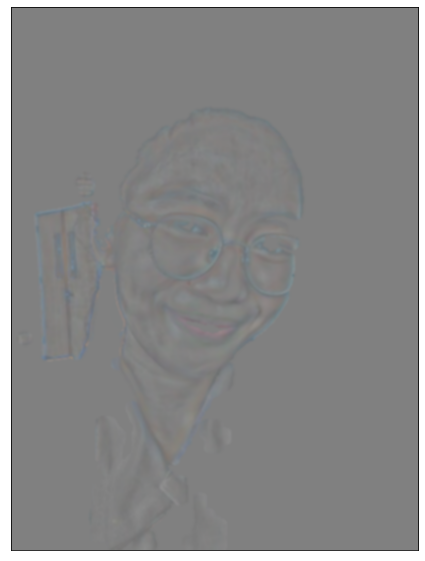

In [ ]:
hpf = cv.GaussianBlur(hpf,(5,5),0)
display(hpf)

## Overlay high pass on original image

In [ ]:
# function for blending two images
def blend(img1, img2):
  first_img = img1.astype(float)/255  
  second_img = img2.astype(float)/255 # make float on range 0-1

  mask = first_img >= 0.5 # generate boolean mask of everywhere a > 0.5 
  ab = np.zeros_like(first_img) # generate an output container for the blended image 

  # now do the blending 
  ab[~mask] = (2*first_img*second_img)[~mask] # 2ab everywhere a<0.5
  ab[mask] = (1-2*(1-first_img)*(1-second_img))[mask] # else this

  return (ab*255).astype(np.uint8) # convert back to cv2 format

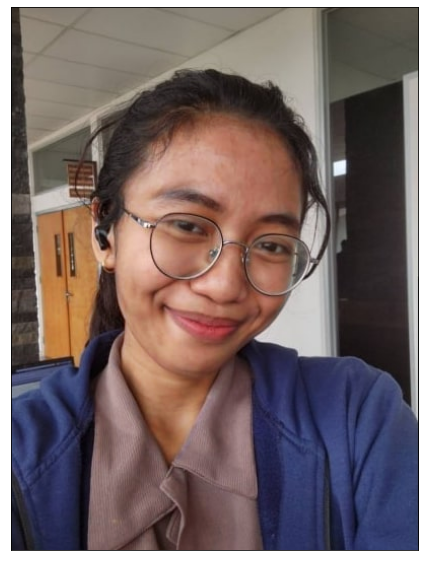

In [ ]:
result = blend(img, hpf)
display(result)

Because the result from overlaying high pass on original image is the opposite of what we want, we need to subtract the result from 255 (invert)

## Invert high pass

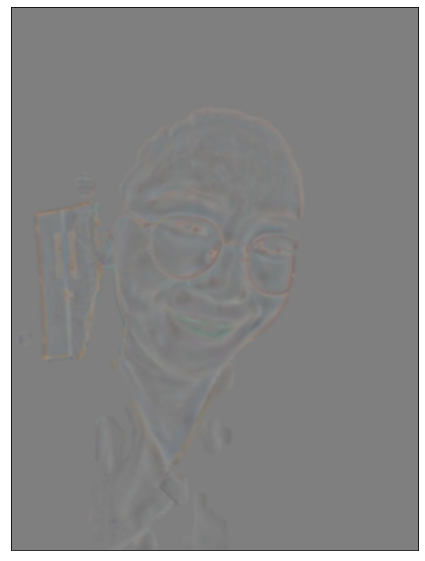

In [ ]:
hpfInv = (255-hpf)
display(hpfInv)

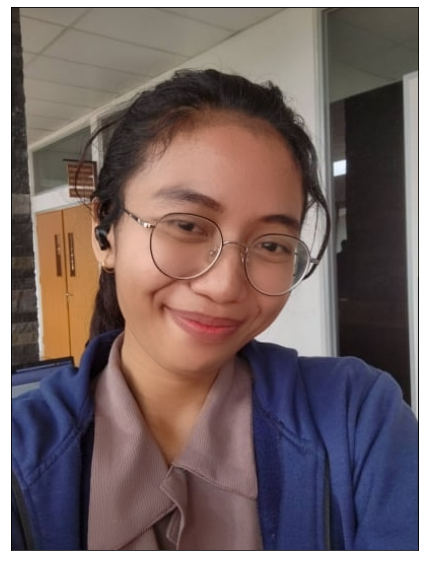

In [ ]:
result2 = blend(img, hpfInv)
display(result2)

## Compare the result with original image

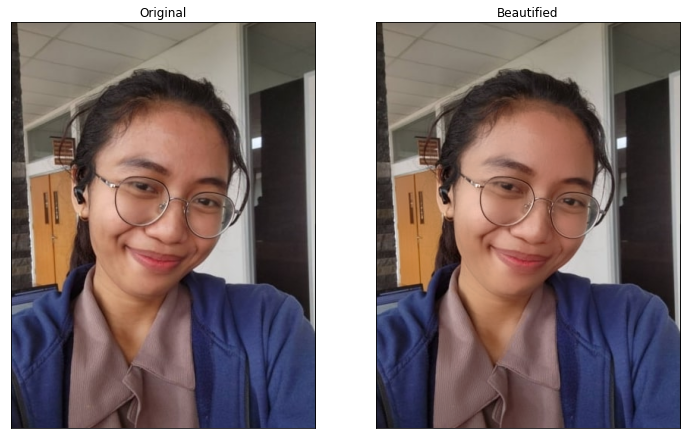

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(121),plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv.cvtColor(result2, cv.COLOR_BGR2RGB)),plt.title('Beautified')
plt.xticks([]), plt.yticks([])
plt.show()

We can see that the result is what we want